In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "03_image_models/03c_alexnet.ipynb"
_nb_title = "Flowers Image Classification using AlexNet"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Flowers Image Classification using AlexNet&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F03_image_models%2F03c_alexnet.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F03_image_models%2F03c_alexnet.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03c_alexnet.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03c_alexnet.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/03_image_models/03c_alexnet.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Flowers Image Classification with AlexNet
In this notebook, we use AlexNet to classify the tf-flowers dataset.

This is mainly a historical curiosity. If you wish to roll your network using
low-level Keras layers, we suggest using [Squeezenet](03d_squeezenet.ipynb).


## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.1
Found GPU at: /device:GPU:0


In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 227
IMG_WIDTH = 227
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://cloud-ml-data/img/flower_photos/*"),
                 "gs://cloud-ml-data/img/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## AlexNet


In [5]:
def create_model():
    layers = [
        tf.keras.Input([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], name='image_input'),
        tf.keras.layers.Conv2D(filters=96, 
                               kernel_size=(11, 11), 
                               strides=(4, 4), 
                               padding='valid', 
                               activation='relu',
                               name='l1_conv'),
        tf.keras.layers.Conv2D(filters=256, 
                               kernel_size=(5, 5), 
                               strides=(1, 1), 
                               padding='same', 
                               activation='relu',
                               name='l2_conv'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                  strides=(2, 2),
                                  padding='valid',
                                  name='l3_maxpool'
        ),
        tf.keras.layers.Conv2D(filters=384, 
                               kernel_size=(3, 3), 
                               strides=(1, 1), 
                               padding='same', 
                               activation='relu',
                               name='l4_conv'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                  strides=(2, 2),
                                  padding='valid',
                                  name='l5_maxpool'
        ),
        tf.keras.layers.Conv2D(filters=384, 
                               kernel_size=(3, 3), 
                               strides=(1, 1), 
                               padding='same', 
                               activation='relu',
                               name='l6_conv'),
        tf.keras.layers.Conv2D(filters=256, 
                               kernel_size=(3, 3), 
                               strides=(1, 1), 
                               padding='same', 
                               activation='relu',
                               name='l7_conv'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                  strides=(2, 2),
                                  padding='valid',
                                  name='l8_maxpool'
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
    ]
    
    return tf.keras.Sequential(layers, name='flower_classification')

In [6]:
import os

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32):
    train_dataset = (tf.data.TextLineDataset(
        "gs://cloud-ml-data/img/flower_photos/train_set.csv").
        map(decode_csv)).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
        "gs://cloud-ml-data/img/flower_photos/eval_set.csv").
        map(decode_csv)).batch(32) # this doesn't matter

    model = create_model()
    
    model.compile(optimizer='Adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=False),
                  metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
l1_conv (Conv2D)             (None, 55, 55, 96)        34944     
_________________________________________________________________
l2_conv (Conv2D)             (None, 55, 55, 256)       614656    
_________________________________________________________________
l3_maxpool (MaxPooling2D)    (None, 27, 27, 256)       0         
_________________________________________________________________
l4_conv (Conv2D)             (None, 27, 27, 384)       885120    
_________________________________________________________________
l5_maxpool (MaxPooling2D)    (None, 13, 13, 384)       0         
_________________________________________________________________
l6_conv (Conv2D)             (None, 13, 13, 384)       1327488   
_________________________________________________________________
l7_conv (Conv2D)             (None, 13, 13, 2

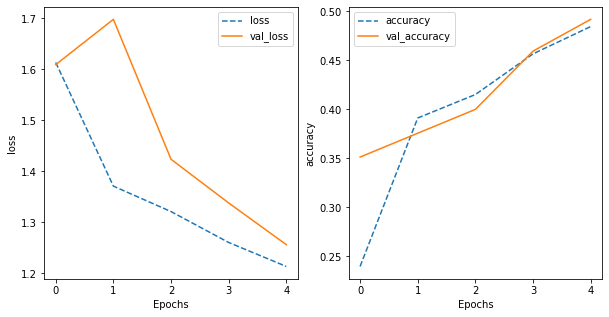

In [7]:
model = train_and_evaluate()

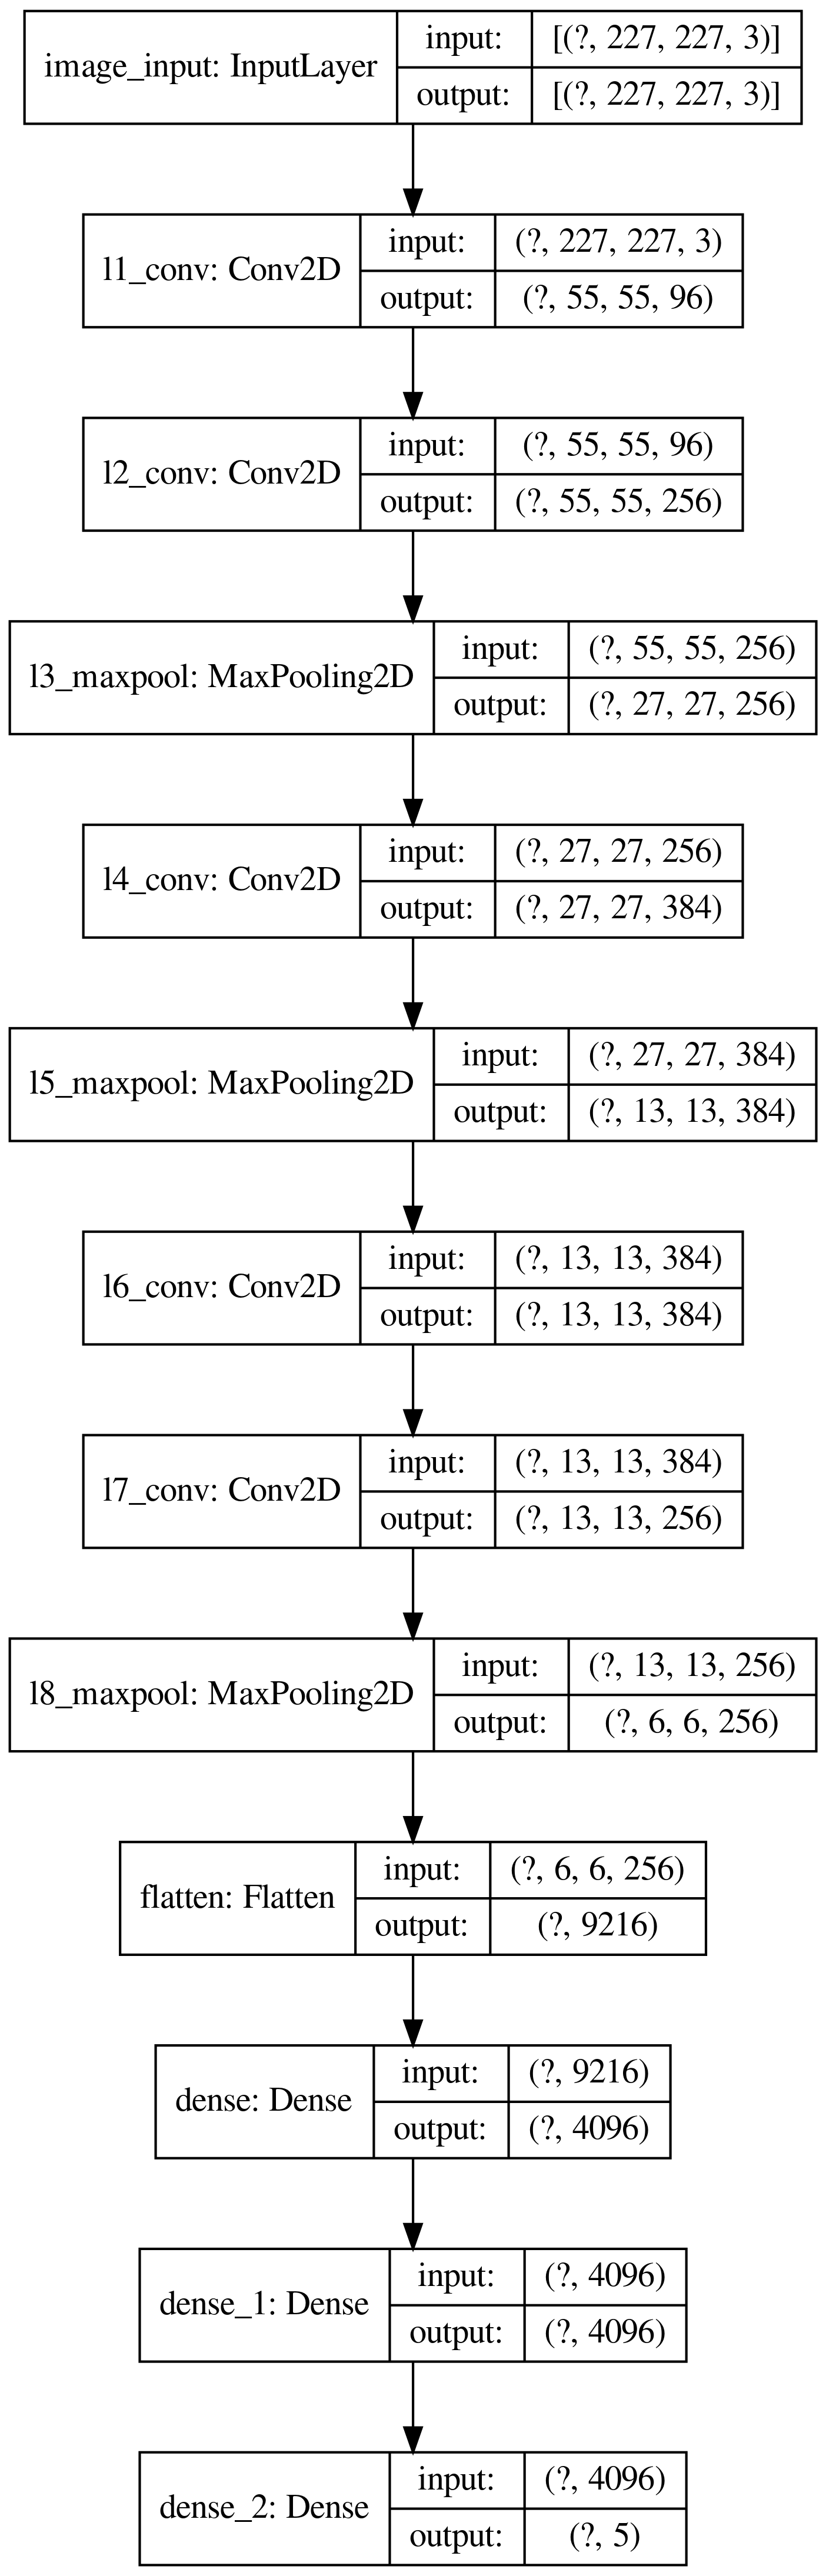

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='alexnet.png', dpi=300)

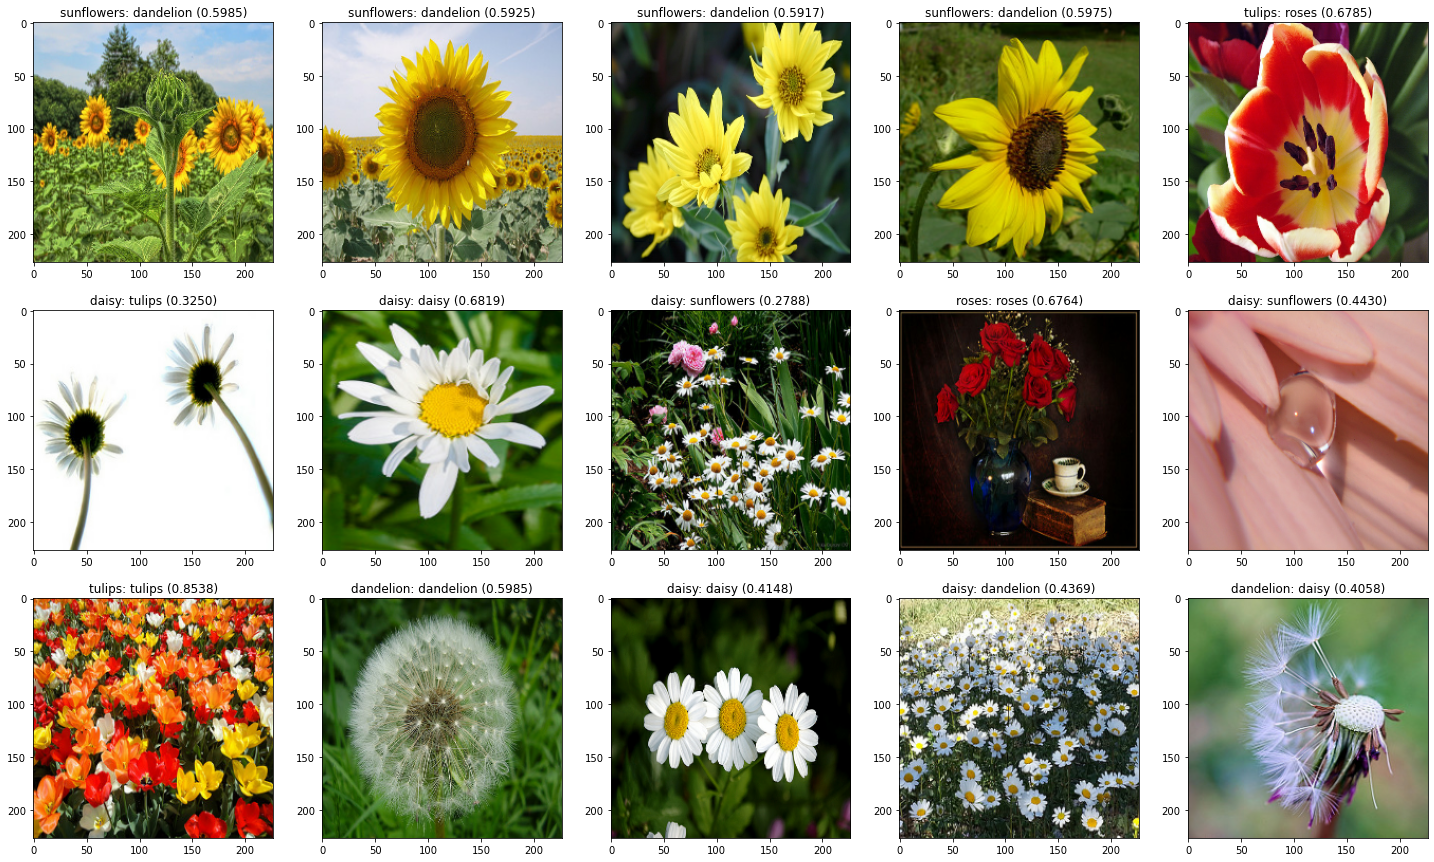

In [13]:
plot_predictions(model, "gs://cloud-ml-data/img/flower_photos/eval_set.csv")

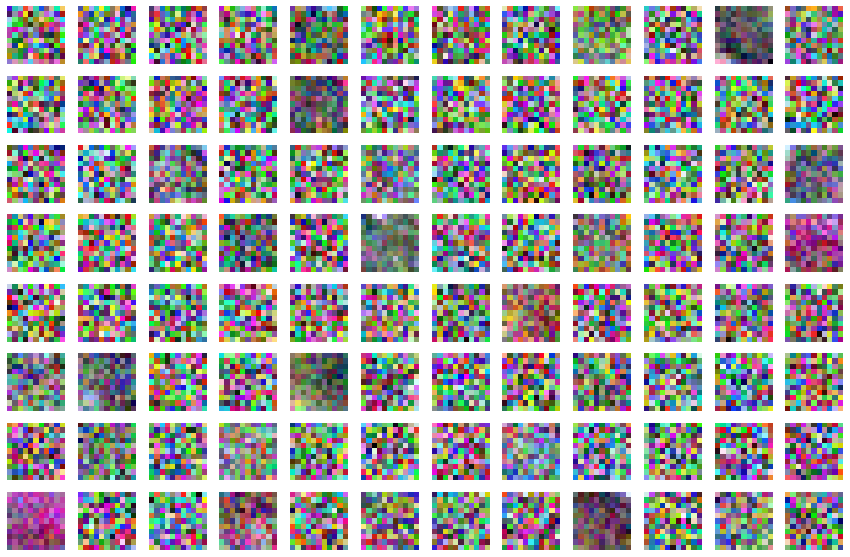

In [34]:
def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 0 # 11x11
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(8, 12, figsize=(15,10))
  for iter in range(96):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, :, :, iter]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[iter//12][iter%12].imshow(weights)
    ax[iter//12][iter%12].axis('off')

show_trained_weights(model)

## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.